# Letting it all out

- https://adventofcode.com/2022/day/16

The puzzles are getting tricker! This is, in essence, an optimisation problem.

Start with figuring out how many steps it'll take to move from any given valve to any of the other valves, because there is no point in calculating this each time you want to evaluate what valve next to visit. You can use the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) to do this.

Next, the number of valves with a non-zero flow rate is low enough that we can use a breath-first search across all the different possible paths; keeping a mapping from visited nodes to pressure relieved to only follow up on a path that visits the same valves in a different order leading to a better value.


In [1]:
import re
from collections import deque
from contextlib import suppress
from dataclasses import dataclass
from functools import cached_property
from itertools import permutations
from typing import Final, Iterator, NamedTuple, Self

LINE: Final[re.Pattern[str]] = re.compile(
    r"^Valve (?P<name>[A-Z]{2}) has flow rate=(?P<rate>\d+); "
    r"(?:tunnels lead to valves|tunnel leads to valve) (?P<valves>[A-Z, ]*)$"
)


class Valve(NamedTuple):
    name: str
    rate: int
    valves: frozenset[str]

    @classmethod
    def from_line(cls, line: str) -> Self:
        match = LINE.match(line)
        assert match is not None
        rate = int(match["rate"])
        valves = frozenset(v.strip() for v in match["valves"].split(","))
        return cls(match["name"], rate, valves)

    def __repr__(self) -> str:
        return (
            f"{type(self).__name__}({self.name}, {self.rate}, "
            f"[{','.join(sorted(self.valves))}])"
        )


@dataclass
class TunnelStep:
    valve: Valve
    time_left: int = 30
    total_released: int = 0
    visited: frozenset[Valve] = frozenset()

    def traverse(self, graph: "Graph") -> Iterator[Self]:
        for valve, steps in graph.distances[self.valve].items():
            if valve in self.visited or not valve.rate:
                # either we already opened the valve here, or it is not worth
                # stopping here as the effect would be 0.
                continue
            if (time_left := self.time_left - steps - 1) <= 0:
                # no point in going here, the result would be 0.
                continue
            yield __class__(
                valve,
                time_left,
                self.total_released + valve.rate * time_left,
                self.visited | {valve},
            )


class Graph:
    def __init__(self, nodes: dict[str, Valve]):
        self.nodes = nodes

    @classmethod
    def from_text(cls, text: str) -> Self:
        return cls({(v := Valve.from_line(line)).name: v for line in text.splitlines()})

    @cached_property
    def distances(self) -> dict[Valve, dict[Valve, int]]:
        """Minimal distances to move from one valve to another

        Uses the Floyd-Warshall algorithm to find the minimum distances from
        any node in the graph to any other node.
        """
        graph = self.nodes
        dist: dict[Valve, dict[Valve, int]] = {
            v: {graph[n]: 1 for n in v.valves} for v in graph.values()
        }
        max = len(graph)
        for k, i, j in permutations(graph.values(), r=3):
            with suppress(KeyError):
                dist[i][j] = min(dist[i][k] + dist[k][j], dist[i].get(j, max))
        return dist

    def max_pressure_reliefs(self, remaining: int = 30) -> dict[frozenset[Valve], int]:
        max_relief: dict[frozenset[Valve], int] = {}
        queue = deque([TunnelStep(self.nodes["AA"], remaining)])
        while queue:
            node = queue.popleft()
            for new in node.traverse(self):
                max_relief[new.visited] = max(
                    max_relief.get(new.visited, 0), new.total_released
                )
                queue.append(new)
        return max_relief

    def optimise_pressure_relief(self) -> int:
        return max(self.max_pressure_reliefs().values())


example = Graph.from_text(
    """\
Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II
"""
)

assert example.optimise_pressure_relief() == 1651

In [2]:
import aocd

graph = Graph.from_text(aocd.get_data(day=16, year=2022))
print("Part 1:", graph.optimise_pressure_relief())

Part 1: 1617


## Part 2: What noise we make when we stamp!

We get the help of an elephant, so we can open more valves!

The trick here is to run through the same search as step one, so simply opening valves with one person. Because this produces a mapping of _set of valves_ -> _relieved pressure_, we can then find all combinations of (partial) paths where the set of valves are _disjoint_, and calculate the maximum pressure relief we can obtain.


In [3]:
from itertools import combinations


def double_up(graph: Graph) -> int:
    paths = graph.max_pressure_reliefs(26)
    return max(
        paths[me] + paths[elephant]
        for me, elephant in combinations(paths, r=2)
        if me.isdisjoint(elephant)
    )


assert double_up(example) == 1707

In [4]:
print("Part 2:", double_up(graph))

Part 2: 2171


## Visualisation

This is what the test valves look like. Red nodes are valves with no pressure to relieve:


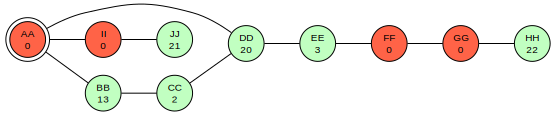

In [5]:
import graphviz
from IPython.display import Markdown, display


def plot_graph(
    graph: Graph,
    edge_attr: dict[str, str] | None = None,
    node_attr: dict[str, str] | None = None,
    **graph_attr: str,
) -> graphviz.Digraph:
    graph_attr = {
        "ratio": "compress",
        "rankdir": "LR",
        **graph_attr,
    }
    edge_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "dir": "none",
        **(edge_attr or {}),
    }
    node_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "fixedsize": "true",
        "style": "filled",
        **(node_attr or {}),
    }
    dot = graphviz.Digraph("orbits", strict=True)
    dot.attr(**graph_attr)
    dot.attr("edge", **edge_attr)
    dot.attr("node", **node_attr)
    for valve in graph.nodes.values():
        dot.node(
            valve.name,
            f"{valve.name}\n{valve.rate}",
            **node_attr,
            shape="doublecircle" if valve.name == "AA" else "circle",
            fillcolor="darkseagreen1" if valve.rate else "tomato",
        )
        for other in valve.valves:
            if other > valve.name:
                dot.edge(valve.name, other)

    return dot.unflatten(3)


display(
    Markdown(
        """\
## Visualisation

This is what the test valves look like. Red nodes are valves with no pressure to relieve:
"""
    )
)
plot_graph(example)

## Visualisation

The puzzle input data is a lot larger:

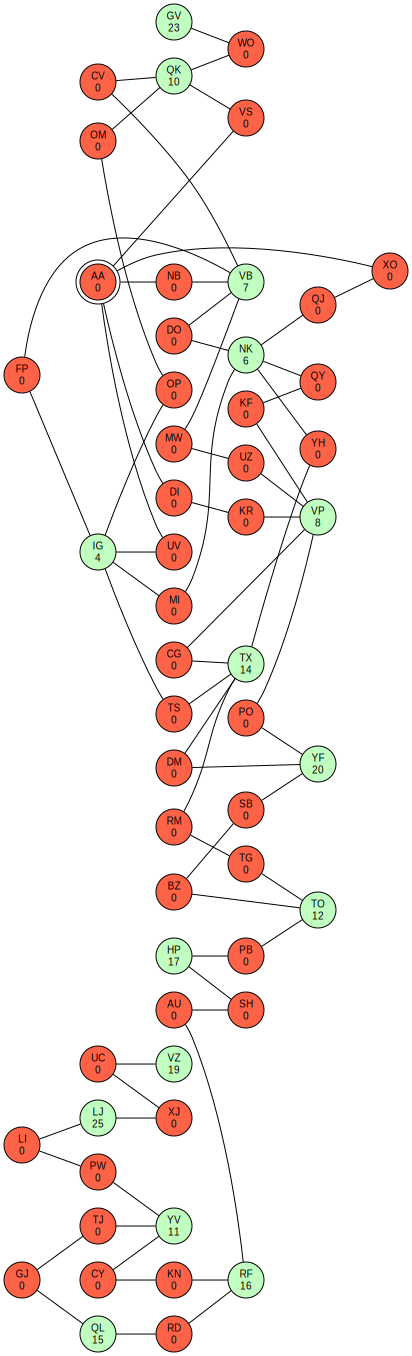

In [6]:
display(Markdown("## Visualisation\n\nThe puzzle input data is a lot larger:"))
plot_graph(graph)